In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10/cifar-10-batches-py/test_batch
/kaggle/input/cifar10/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10/cifar-10-batches-py/readme.html


##  1. Using Convolutional Neural Network for Image Recognition

### Data Preparation

- Load the data

In [2]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

2025-10-31 01:54:46.929497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761875687.158108      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761875687.224905      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


- split the training data and validation data

In [3]:
# 55,000 examples are training set, 5,000 in the validation set, and 10,000 in the test set.
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=1/12, random_state=42
)

In [4]:
x_train.shape

(55000, 28, 28)

In [5]:
x_val.shape

(5000, 28, 28)

### 1.1 
Please implement a CNN for image recognition using the MNIST dataset. You have to design 
your network architecture and analyze the effect of different stride size and filter size.  Also, plot the 
learning curve, accuracy of training and test sets, and distributions of weights and biases. (The 
figures shown below are only for example, you should get the results by yourself.) 

#### 1.1.1  analyze the effect of different stride size and filter size.
- 1. stride=3, filter=3
- 2. stride=3, filter=1
- 3. stride=5, filter=3
- (All set MaxPooling2D (2,2) )

- Build CNN Model

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

def build_cnn_model(s, k, l2_factor):
    model = keras.Sequential()
    
    #CNN
    rows, cols = 28, 28
    
    model.add(layers.Input(shape=(rows, cols, 1)))
    model.add(layers.Rescaling(1./255)) 
    
    model.add(layers.Conv2D(32, strides=(s,s), kernel_size=(k,k), activation='relu', kernel_regularizer=regularizers.l2(l2_factor)))
    model.add(layers.MaxPooling2D((2,2), padding='same'))
    model.add(layers.Conv2D(64, strides=(s,s), kernel_size=(k,k), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_factor)))
    model.add(layers.MaxPooling2D((2,2), padding='same'))
    model.add(layers.Conv2D(128, strides=(s,s), kernel_size=(k,k), activation='relu',  padding='same', kernel_regularizer=regularizers.l2(l2_factor)))
    model.add(layers.Conv2D(128, strides=(s,s), kernel_size=(k,k), activation='relu',  padding='same', kernel_regularizer=regularizers.l2(l2_factor)))
    model.add(layers.MaxPooling2D((2,2), padding='same'))
    
    # Dropout -> Prevent Overfitting
    model.add(layers.Dropout(0.25))
    
    # Flatten -> Convert the previous hidden layer to 1D array []
    model.add(layers.Flatten())
    
    #Output layer
    num_classes = 10
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_factor)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes,activation='softmax'))
    
    #Compile and train model
    model.compile(
        loss= 'sparse_categorical_crossentropy',
        optimizer= 'adam',
        metrics= ['accuracy']
    )
    return model

- Run and Evaluate CNN Model

In [7]:
from tensorflow.keras.callbacks import LambdaCallback

def run_cnn_model(s, k, batch_size, epochs, l2):
    model = build_cnn_model(s, k, l2)
    test_accs, test_losses = [], []

    # Build Callback model for testing data
    test_cb = LambdaCallback(
        on_epoch_end=lambda epoch, logs: (
            (lambda l, a: (test_losses.append(l), test_accs.append(a)))(
                *model.evaluate(x_test, y_test, verbose=True)
            )
        )
    )
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        verbose=True,
        callbacks=[test_cb]  #evaluate testing data in each epoch
    )

    return model, history, test_accs, test_losses

#### Model 1: stride=3, filter=3*3

In [8]:
model33, history33, test_acc33, test_loss33 = run_cnn_model(3,3,128,40,0)

I0000 00:00:1761875702.006394      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/40


I0000 00:00:1761875706.591173      97 service.cc:148] XLA service 0x7ae668004020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761875706.592038      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761875706.974425      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


 56/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1927 - loss: 2.1995

I0000 00:00:1761875710.106972      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8509 - loss: 0.4585
430/430 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.4959 - loss: 1.4041 - val_accuracy: 0.8714 - val_loss: 0.3928
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9147 - loss: 0.2624
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8667 - loss: 0.4294 - val_accuracy: 0.9280 - val_loss: 0.2193
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9394 - loss: 0.1974
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9188 - loss: 0.2746 - val_accuracy: 0.9496 - val_loss: 0.1645
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9454 - loss: 0.1727
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9383 - loss: 0.2134 - val_accuracy: 0.9516 - val_loss: 0.1475
Epoch 5/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9480 - loss: 0.1642
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9493 - loss: 0.1781 - val_accuracy: 0.9592 - val_loss: 0

#### Model 2: stride=3, filter=5*5

In [9]:
model35, history35, test_acc35, test_loss35 = run_cnn_model(3,5,128,40,0)

Epoch 1/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9198 - loss: 0.2694
430/430 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.4777 - loss: 1.4427 - val_accuracy: 0.9276 - val_loss: 0.2361
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9431 - loss: 0.1774
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9200 - loss: 0.2869 - val_accuracy: 0.9480 - val_loss: 0.1632
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9655 - loss: 0.1095
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9522 - loss: 0.1744 - val_accuracy: 0.9670 - val_loss: 0.1053
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9730 - loss: 0.0964
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9640 - loss: 0.1355 - val_accuracy: 0.9760 - val_loss: 0.0850
Epoch 5/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9700 - loss: 0.1013
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9717 - loss: 0.1034 - val_accuracy: 0.9742 - 

#### Model 3: stride=5, filter=3*3

In [10]:
model53, history53, test_acc53, test_loss53 = run_cnn_model(5,3,128,40,0)

Epoch 1/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7481 - loss: 0.7766
430/430 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.3917 - loss: 1.6670 - val_accuracy: 0.7598 - val_loss: 0.7295
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8290 - loss: 0.5393
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7731 - loss: 0.7189 - val_accuracy: 0.8404 - val_loss: 0.4872
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8560 - loss: 0.4512
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8456 - loss: 0.5098 - val_accuracy: 0.8688 - val_loss: 0.4071
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8705 - loss: 0.4171
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8667 - loss: 0.4433 - val_accuracy: 0.8828 - val_loss: 0.3703
Epoch 5/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8760 - loss: 0.3910
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8814 - loss: 0.3953 - val_accuracy: 0.8968 - 

#### Compare with these 3 models

In [13]:
loss33, acc33 =  model33.evaluate(x_test, y_test, verbose=0)
print(f"[Model1: stride=3, kernel=3*3] test_acc={acc33:.4f}, test_loss={loss33:.4f}")
loss35, acc35 =  model35.evaluate(x_test, y_test, verbose=0)
print(f"[Model2: stride=3, kernel=5*5] test_acc={acc35:.4f}, test_loss={loss35:.4f}")
loss53, acc53 =  model53.evaluate(x_test, y_test, verbose=0)
print(f"[Model3: stride=5, kernel=3*3] test_acc={acc53:.4f}, test_loss={loss53:.4f}")

[Model1: stride=3, kernel=3*3] test_acc=0.9731, test_loss=0.1573
[Model2: stride=3, kernel=5*5] test_acc=0.9851, test_loss=0.0784
[Model3: stride=5, kernel=3*3] test_acc=0.9157, test_loss=0.3574


Based on both accuracy and loss values, the configuration with **stride = 3 and kernel = 5x5** achieves **the best overall performance (the highest accuracy and lowest loss)** which provides a good balance between accuracy and stability. 

### 1.1.2 Plot the learning curve, accuracy of training and test sets, and distributions of weights and biases.
- Utilize `model33` as an example, you can change the model name to `35` or `53` and different results would be presented.

#### 0. Preparation

In [15]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

#### 1. Accuracy

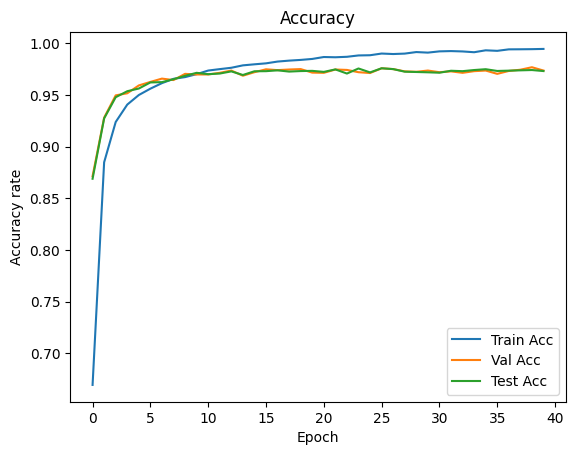

In [16]:
plt.figure()
plt.plot(history33.history['accuracy'], label='Train Acc') #you can change it to history31 / history53
plt.plot(history33.history['val_accuracy'], label='Val Acc')
plt.plot(test_acc33, label='Test Acc')#you can change it to test_acc31 / test_acc53
plt.xlabel('Epoch'); plt.ylabel('Accuracy rate'); plt.legend(); plt.title('Accuracy')
plt.show()

#### 2. Learning Curve

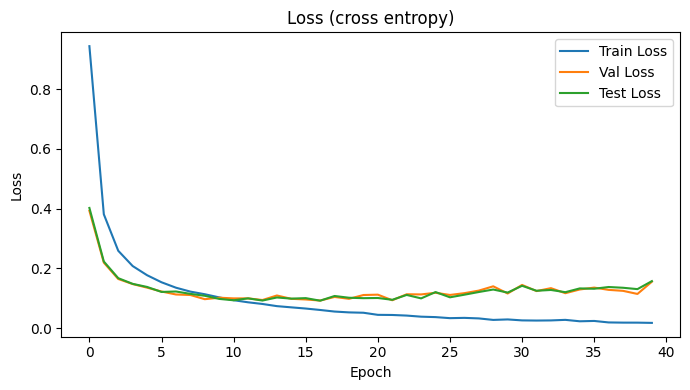

In [17]:
plt.figure(figsize=(7,4))
plt.plot(history33.history.get('loss', []), label='Train Loss')#you can change it to history31 / history53
plt.plot(history33.history.get('val_loss', []), label='Val Loss')
plt.plot(test_loss33, label='Test Loss')#you can change it to test_loss31 / test_loss53
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss (cross entropy)')
plt.legend(); plt.tight_layout(); plt.show()

#### 3. Distributions of weights and biases

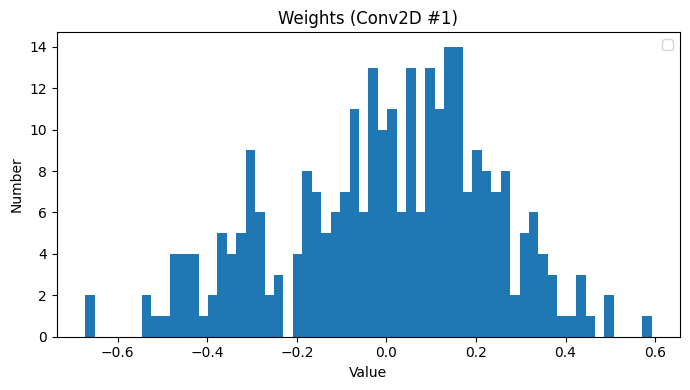

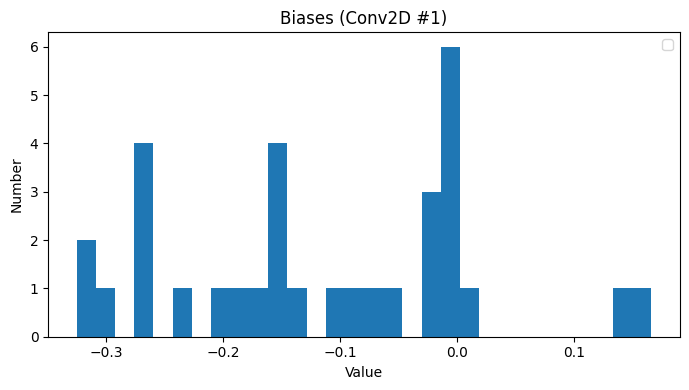

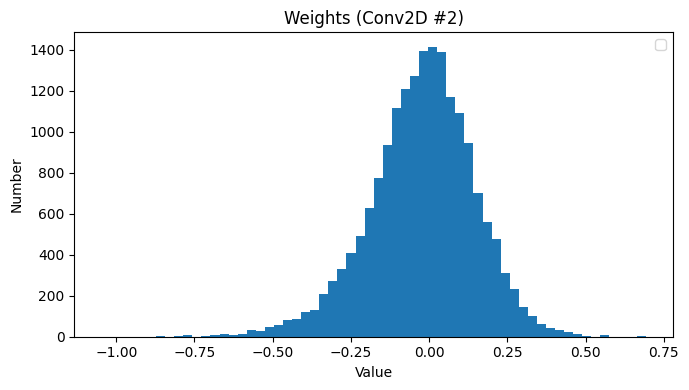

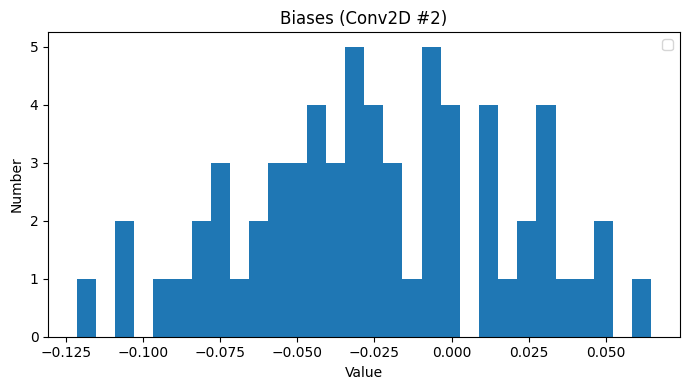

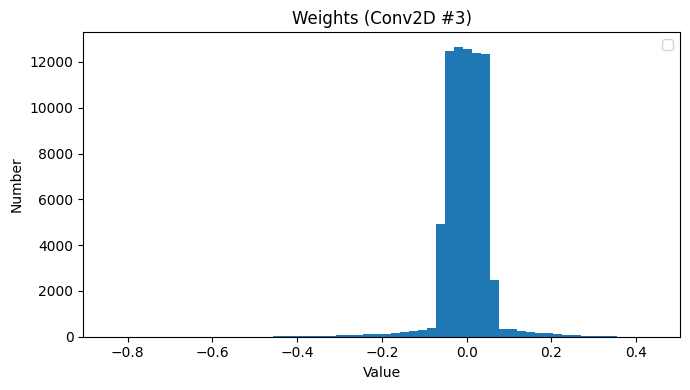

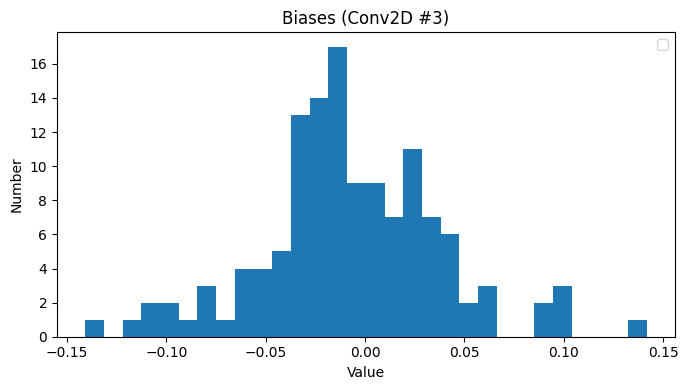

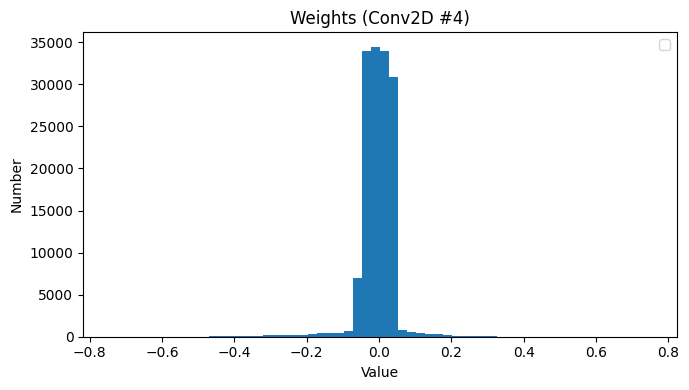

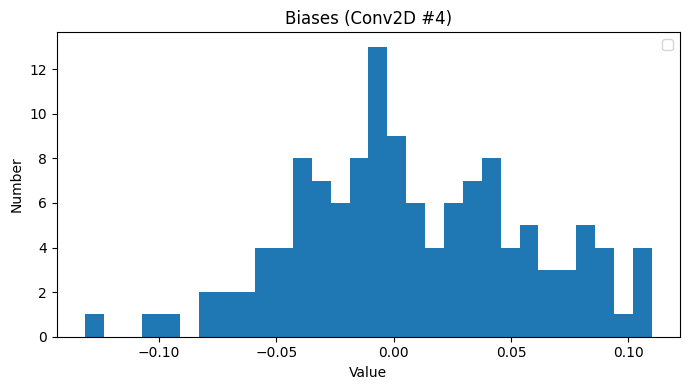

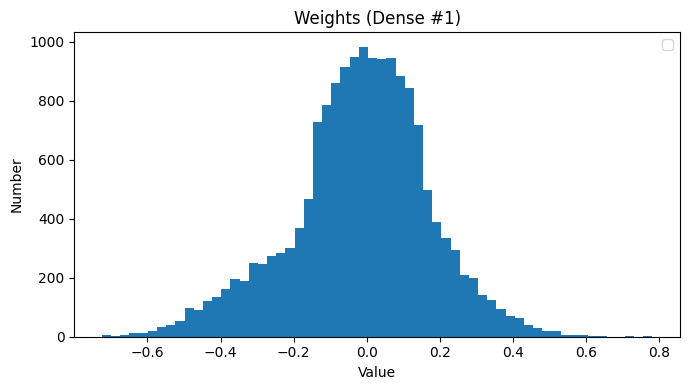

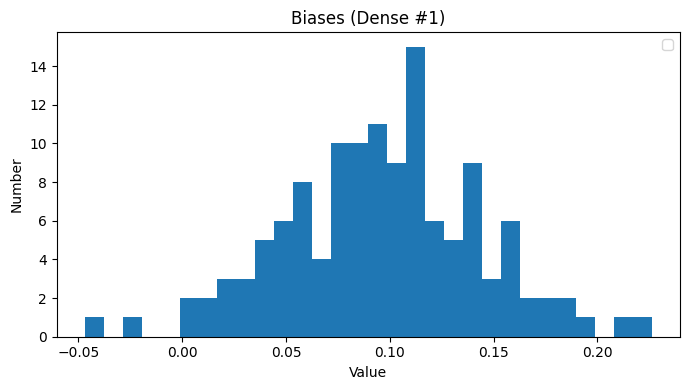

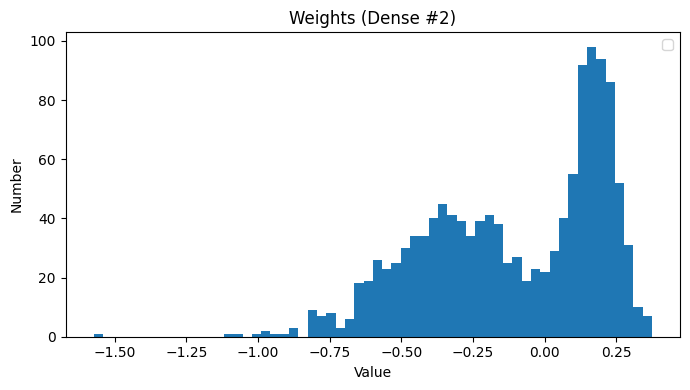

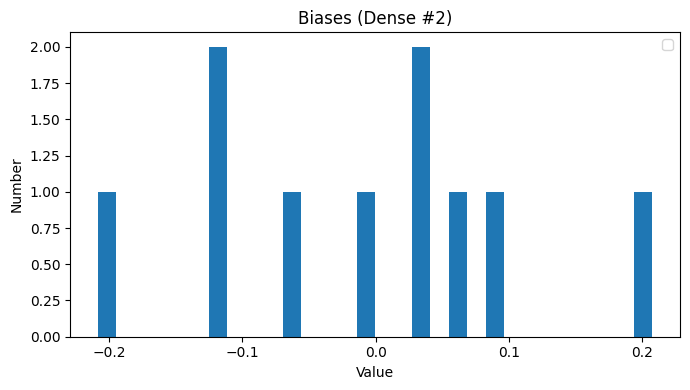

In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt

conv_idx, dense_idx = 0, 0
for layer in model33.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        conv_idx += 1
        w, *maybe_b = layer.get_weights()
        b = maybe_b[0] if maybe_b else None

        plt.figure(figsize=(7,4))
        plt.hist(w.flatten(), bins=60)
        plt.xlabel('Value'); plt.ylabel('Number'); plt.legend()
        plt.title(f'Weights (Conv2D #{conv_idx})')
        plt.tight_layout(); plt.show()

        if b is not None:
            plt.figure(figsize=(7,4))
            plt.hist(b.flatten(), bins=30)
            plt.xlabel('Value'); plt.ylabel('Number'); plt.legend()
            plt.title(f'Biases (Conv2D #{conv_idx})')
            plt.tight_layout(); plt.show()

    elif isinstance(layer, tf.keras.layers.Dense):
        dense_idx += 1
        w, *maybe_b = layer.get_weights()
        b = maybe_b[0] if maybe_b else None

        plt.figure(figsize=(7,4))
        plt.hist(w.flatten(), bins=60)
        plt.xlabel('Value'); plt.ylabel('Number'); plt.legend()
        plt.title(f'Weights (Dense #{dense_idx})')
        plt.tight_layout(); plt.show()

        if b is not None:
            plt.figure(figsize=(7,4))
            plt.hist(b.flatten(), bins=30)
            plt.xlabel('Value'); plt.ylabel('Number'); plt.legend()
            plt.title(f'Biases (Dense #{dense_idx})')
            plt.tight_layout(); plt.show()

### 1-2 
Show some examples of correctly classified and miss-classified images and discuss your results.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


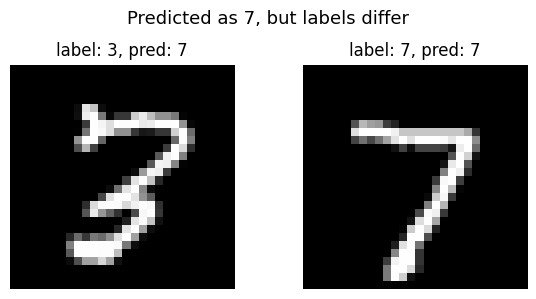

In [19]:
import numpy as np
import matplotlib.pyplot as plt

#Get predicted results
y_pred_probs = model33.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Find index
correct_idx = np.where(y_pred == y_test)[0]
wrong_idx = np.where(y_pred != y_test)[0]

# Randomly choose samples
for idx_c in correct_idx:
    pred_label = y_pred[idx_c]
    true_label = y_test[idx_c]

# find the same pred but different label
    candidates = [i for i in wrong_idx if y_pred[i] == pred_label and y_test[i] != true_label]
    if len(candidates) > 0:
        idx_w = candidates[0]
        break

plt.figure(figsize=(6,3))

#plot the miss-classified image
plt.subplot(1,2,1)
plt.imshow(x_test[idx_w].reshape(28,28), cmap='gray')
plt.title(f"label: {y_test[idx_w]}, pred: {y_pred[idx_w]}")
plt.axis('off')

#plot the correctly classified image
plt.subplot(1,2,2)
plt.imshow(x_test[idx_c].reshape(28,28), cmap='gray')
plt.title(f"label: {y_test[idx_c]}, pred: {y_pred[idx_c]}")
plt.axis('off')

plt.suptitle(f"Predicted as {pred_label}, but labels differ", fontsize=13)
plt.tight_layout()
plt.show()

The example already presented above, the LHS is miss-classified images and the RHS is correctly classified ones. I think why miss-classified might attribute to some reasons,
- Flaws appear in the images which comfused the model to make the decision (e.g. **label 3 pred 7**).
- rotation, slant (e.g. **label 1 pred 7 ,and label 7 pred 1**) might make two digits look alike to early conv filters.

### 1-3
Following 1-2, observe the feature maps from different convolutional layers and describe how a feature map changes with increasing depth. 

In [ ]:
model33.summary()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


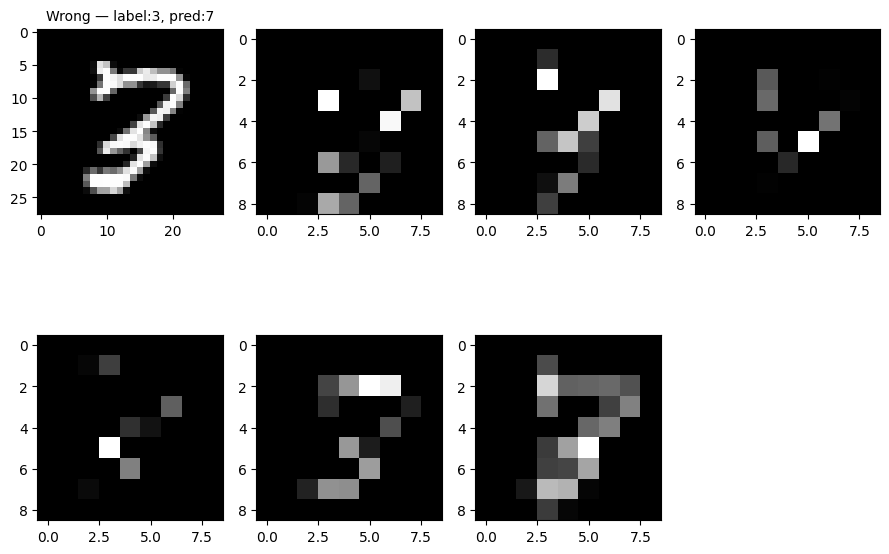

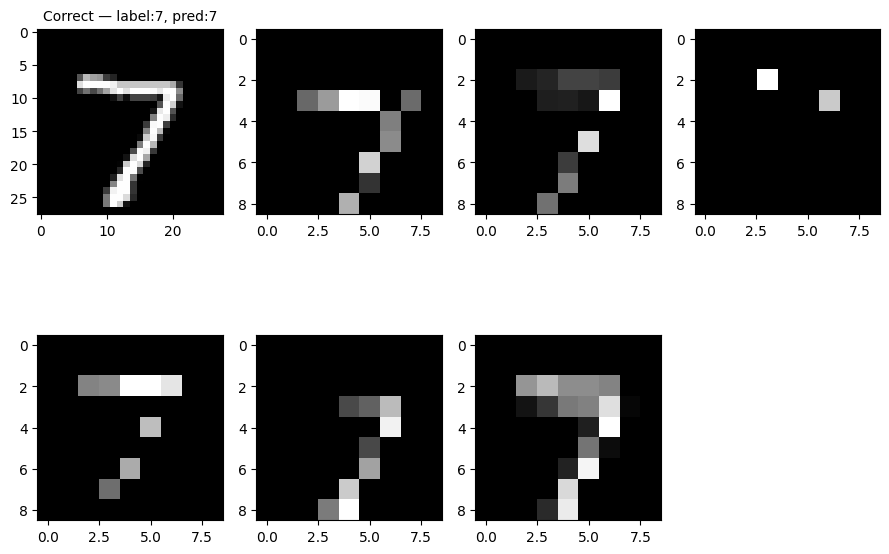

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.models import Model

# Data Preparation
if x_test.ndim == 3:
    x_test = x_test[..., np.newaxis]
x_test = x_test.astype("float32")
y_pred_probs = model33.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
correct_idx = np.where(y_pred == y_test)[0]
wrong_idx   = np.where(y_pred != y_test)[0]

pairs = []
for idx_c in correct_idx:
    pred_label = y_pred[idx_c]
    true_label = y_test[idx_c]
    candidates = [i for i in wrong_idx if y_pred[i] == pred_label and y_test[i] != true_label]
    if len(candidates) > 0:
        idx_w = candidates[0]
        pairs.append((idx_c, idx_w, pred_label))
        break

idx_c, idx_w, pred_label = pairs[0]

# Build Model
inp = Input(shape=tuple(x_test.shape[1:]), dtype=tf.float32)
x = inp
first_conv_out = None
for lyr in model33.layers:
    x = lyr(x)
    if first_conv_out is None and isinstance(lyr, Conv2D):
        first_conv_out = x
feat_model = Model(inputs=inp, outputs=first_conv_out)

# Define the function of ploting feature map
def plot_feature_map(img, title):
    act = feat_model.predict(img[None, ...], verbose=0)[0]
    rows, cols = 2, 3
    k = min(act.shape[-1], rows * cols)
    plt.figure(figsize=(9, 3.2 * rows))
    # Original
    plt.subplot(rows, cols + 1, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(title, fontsize=10)
    plt.axis('on')
    
    # Feature maps
    for i in range(k):
        plt.subplot(rows, cols + 1, i + 2)
        plt.imshow(act[:, :, i], cmap='gray')
        plt.axis('on')
    plt.tight_layout()
    plt.show()

# Plot
plot_feature_map(x_test[idx_w], f"Wrong — label:{y_test[idx_w]}, pred:{y_pred[idx_w]}")
plot_feature_map(x_test[idx_c], f"Correct — label:{y_test[idx_c]}, pred:{y_pred[idx_c]}")


- As the network depth increases, the feature maps gradually evolve from capturing low-level visual details to representing high-level semantic information.
  - In the **first convolutional layer**, the original shape of the digit is still visible.
  - In **intermediate layers**, the model **combines these low-level patterns into more complex motifs** such as stroke intersections or local contours, and the maps **become sparser** and harder to interpret visually.
  - In the **deeper layers**, the activations correspond to highly abstract class-specific features; the maps **no longer resemble the input image but instead highlight meaningful concepts** (e.g., loops, vertical strokes) that distinguish one class from another.

- Overall, with increasing depth:
  - **spatial resolution decreases**
  - **representations become more abstract**
  - **the model focuses on the most discriminative semantic features**

### 1.4 L2 regularization's effect

In [21]:
model33_l2, history33_l2, test_acc33_l2, test_loss33_l2 = run_cnn_model(3,3,128,40,0.001) #Set L2 factor=0.001

Epoch 1/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8461 - loss: 0.6028
430/430 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.4647 - loss: 1.6427 - val_accuracy: 0.8670 - val_loss: 0.5466
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9048 - loss: 0.4362
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8472 - loss: 0.6129 - val_accuracy: 0.9154 - val_loss: 0.3896
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9066 - loss: 0.4242
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9029 - loss: 0.4623 - val_accuracy: 0.9250 - val_loss: 0.3633
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9359 - loss: 0.3405
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9226 - loss: 0.4025 - val_accuracy: 0.9444 - val_loss: 0.3039
Epoch 5/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9371 - loss: 0.3325
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9321 - loss: 0.3672 - val_accuracy: 0.9456 - 

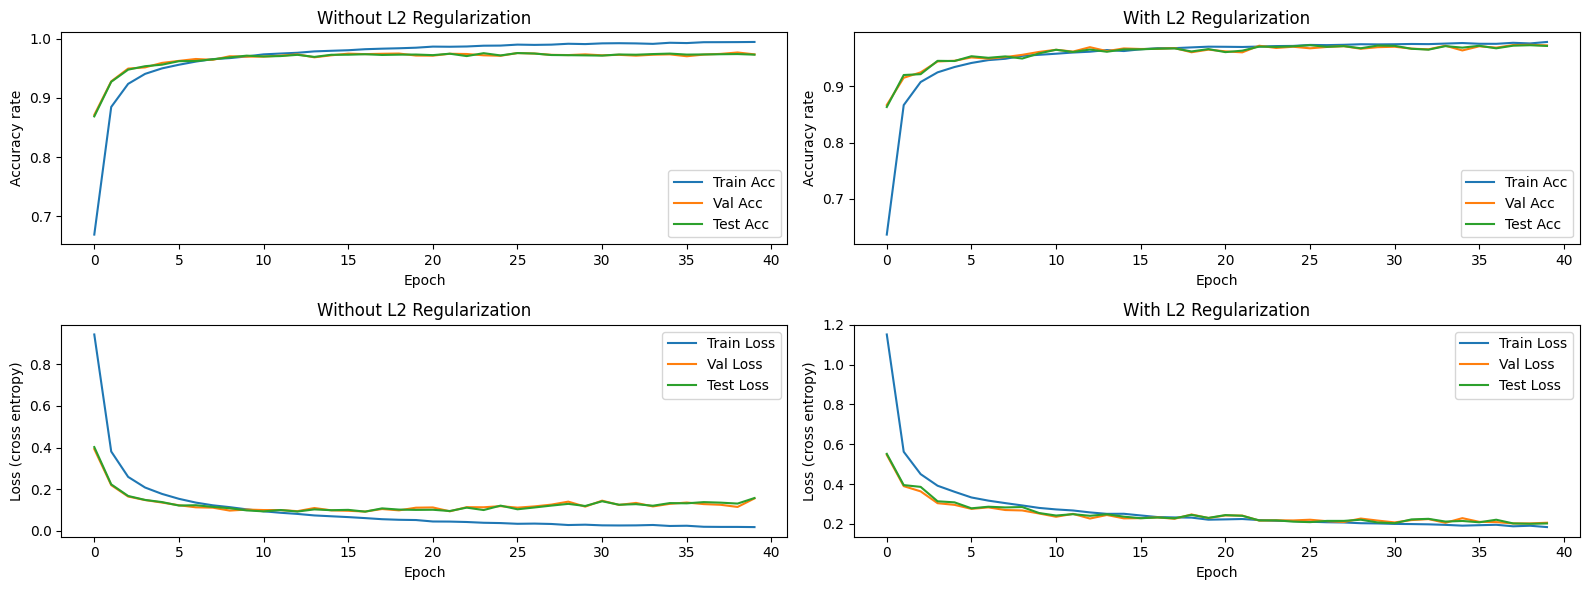

In [22]:
plt.figure(figsize=(16, 6))

#Accuracy
plt.subplot(2, 2, 1)
plt.plot(history33.history['accuracy'], label='Train Acc')
plt.plot(history33.history['val_accuracy'], label='Val Acc')
plt.plot(test_acc33, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy rate')
plt.legend()
plt.title('Without L2 Regularization')

plt.subplot(2, 2, 2)
plt.plot(history33_l2.history['accuracy'], label='Train Acc')
plt.plot(history33_l2.history['val_accuracy'], label='Val Acc')
plt.plot(test_acc33_l2, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy rate')
plt.legend()
plt.title('With L2 Regularization')

#Loss (Learning Curve)
plt.subplot(2, 2, 3)
plt.plot(history33.history['loss'], label='Train Loss')
plt.plot(history33.history['val_loss'], label='Val Loss')
plt.plot(test_loss33, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross entropy)')
plt.legend()
plt.title('Without L2 Regularization')

plt.subplot(2, 2, 4)
plt.plot(history33_l2.history['loss'], label='Train Loss')
plt.plot(history33_l2.history['val_loss'], label='Val Loss')
plt.plot(test_loss33_l2, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross entropy)')
plt.legend()
plt.title('With L2 Regularization')

plt.tight_layout()
plt.show()

#### Accuracy / Learning Curve
- As shown in the figure, **without L2 regularization**, the training accuracy **quickly reaches nearly 1.0** while validation and testing accuracies fluctuate, indicating mild overfitting. The training loss drops almost to zero whereas the validation loss begins to increase in later epochs.
-  **With L2 regularization**, the training curve becomes smoother, and **all accuracies (train/val/test) align closely**. The **loss curves remain stable and consistent** across datasets, demonstrating **improved generalization and reduced overfitting**.

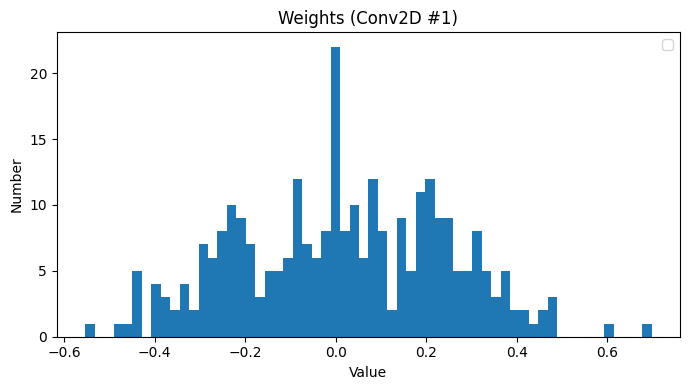

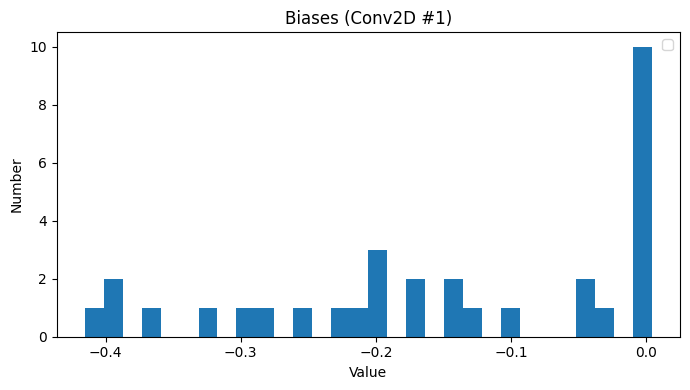

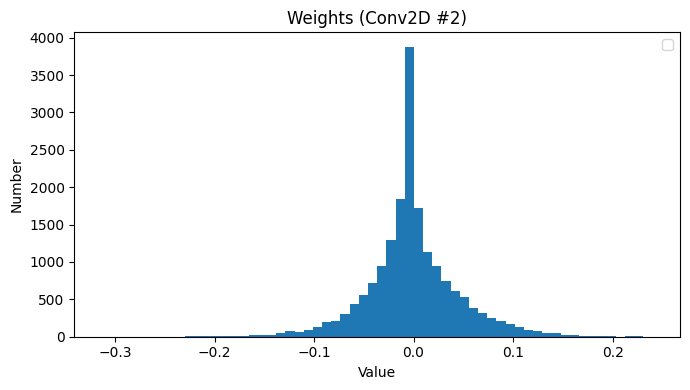

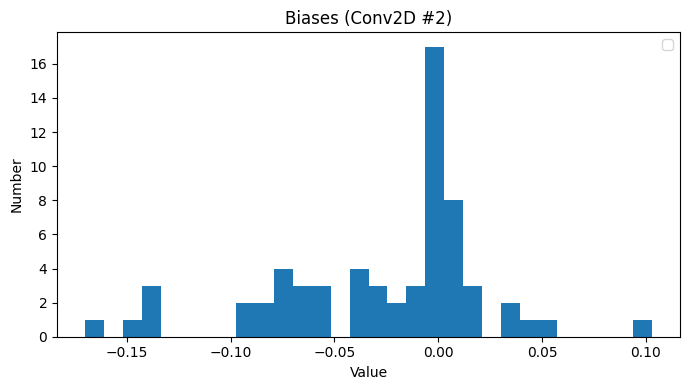

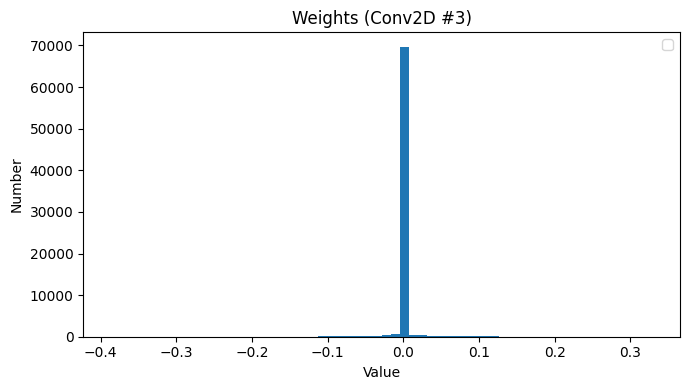

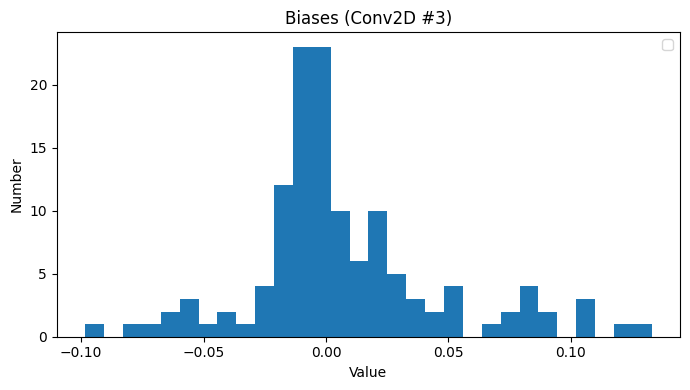

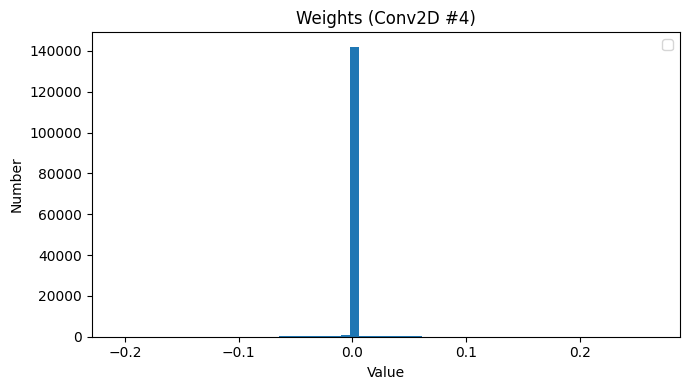

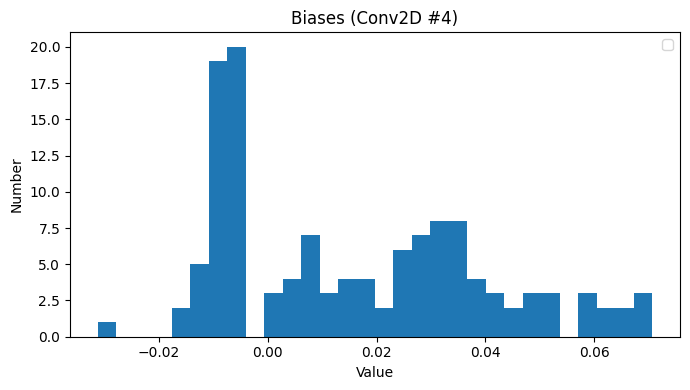

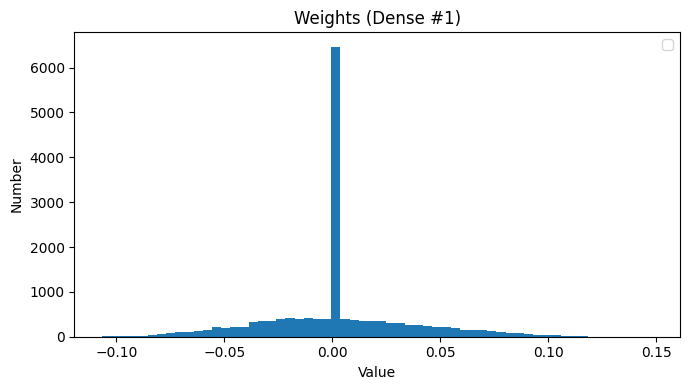

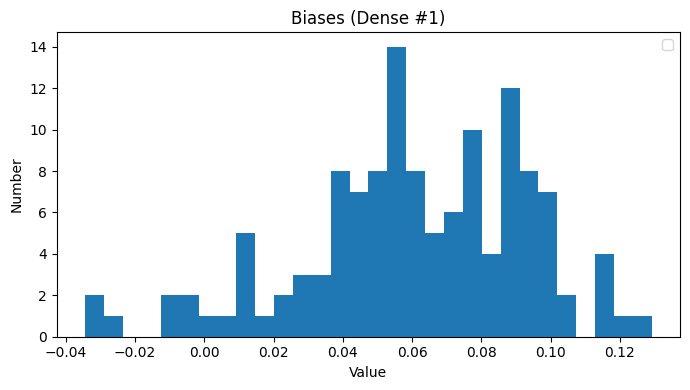

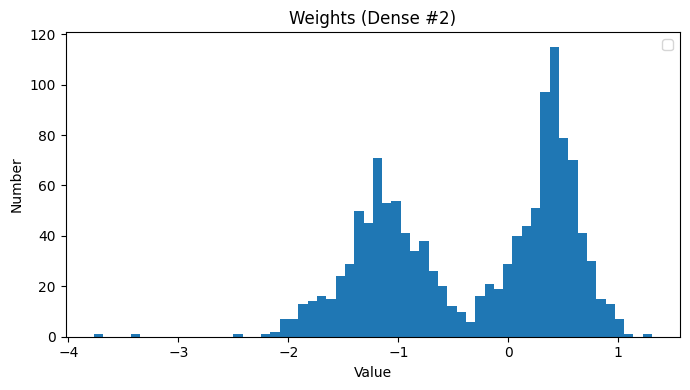

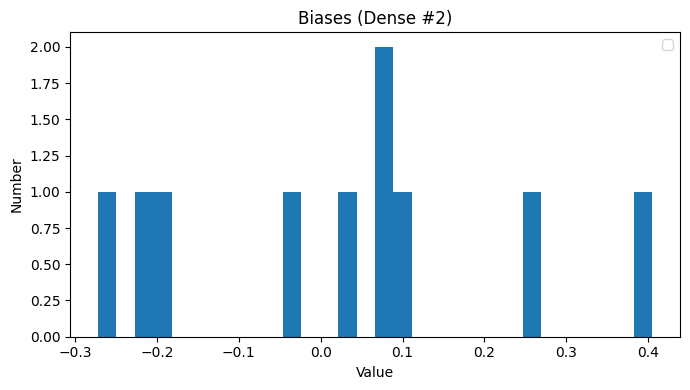

In [23]:
#Histograms of bias and weights (with L2 regularization)
conv_idx, dense_idx = 0, 0
for layer in model33_l2.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        conv_idx += 1
        w, *maybe_b = layer.get_weights()
        b = maybe_b[0] if maybe_b else None

        plt.figure(figsize=(7,4))
        plt.hist(w.flatten(), bins=60)
        plt.xlabel('Value'); plt.ylabel('Number'); plt.legend()
        plt.title(f'Weights (Conv2D #{conv_idx})')
        plt.tight_layout(); plt.show()

        if b is not None:
            plt.figure(figsize=(7,4))
            plt.hist(b.flatten(), bins=30)
            plt.xlabel('Value'); plt.ylabel('Number'); plt.legend()
            plt.title(f'Biases (Conv2D #{conv_idx})')
            plt.tight_layout(); plt.show()

    elif isinstance(layer, tf.keras.layers.Dense):
        dense_idx += 1
        w, *maybe_b = layer.get_weights()
        b = maybe_b[0] if maybe_b else None

        plt.figure(figsize=(7,4))
        plt.hist(w.flatten(), bins=60)
        plt.xlabel('Value'); plt.ylabel('Number'); plt.legend()
        plt.title(f'Weights (Dense #{dense_idx})')
        plt.tight_layout(); plt.show()

        if b is not None:
            plt.figure(figsize=(7,4))
            plt.hist(b.flatten(), bins=30)
            plt.xlabel('Value'); plt.ylabel('Number'); plt.legend()
            plt.title(f'Biases (Dense #{dense_idx})')
            plt.tight_layout(); plt.show()

#### Histogram of the weight distributions
- **Without L2**, weights follow a **near-Gaussian distribution** with a wider spread, allowing large weight magnitudes and leading to potential overfitting.
- **With L2**, **most weights shrink toward zero**, resulting in a sharp peak near zero and a narrower range. This indicates that the regularization term effectively constrains parameter magnitudes, producing a smoother and more generalizable model.

#### Histogram of the bias distributions
- **Without L2**, the biases follow a **near-Gaussian distribution** centered around zero, indicating small symmetric adjustments around the mean output.
- **With L2**, the distribution shifts toward positive values and **becomes more uniform**. Since L2 primarily penalizes weights, the model compensates for the restricted weight magnitudes by adjusting biases more flexibly, leading to a broader range and asymmetric distribution. This illustrates a redistribution of learning effort between weights and biases under regularization constraints.

## 2. Preprocessing Before Using Convolutional Neural Network for Image Recognition

### 0. Data Preparation

In [24]:
import os
import numpy as np
import keras

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

#path
data_dir = "/kaggle/input/cifar10/cifar-10-batches-py"
train_batches = [f"data_batch_{i}" for i in range(1,6)]
test_batch = "test_batch"

#read training data
x_train, y_train = [], []
for batch in train_batches:
    file = os.path.join(data_dir, batch)
    batch_dict = unpickle(file)
    x_train.append(batch_dict[b'data'])
    y_train += batch_dict[b'labels']

x_train = np.concatenate(x_train)
y_train = np.array(y_train)

#read testing data
test_dict = unpickle(os.path.join(data_dir, test_batch))
x_test = test_dict[b'data']
y_test = np.array(test_dict[b'labels'])

In [25]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 3072) (50000,)
(10000, 3072) (10000,)


In [26]:
# reshape + transpose to (N,32,32,3)
x_train = x_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
x_test  = x_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

In [27]:
#observe the distribution of label 0~9
import numpy as np
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


### 2-5 Data Preprocessing

- Normalize the data to [0, 1]

In [ ]:
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

- Randomly split 50000 training data into 45000 training set and 5000 validation set with `train_test_split` (i.e. `test_size`=0.1 )

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=2025, stratify=y_train
)

- One-hot encoding for `y_train`

In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

- Check the shape of x_train, x_val, y_train, y_val

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(45000, 32, 32, 3)
(5000, 32, 32, 3)
(45000, 10)
(5000, 10)


### 2-1 Implement a CNN for image recognition using the CIFAR-10 dataset.

#### 2.1.1  analyze the effect of different stride size and filter size.
- 1. stride=1, filter=3*3
- 2. stride=2, filter=3*3
- 3. stride=1, filter=5*5
- (All set MaxPooling2D (2,2) and BatchNormallization() )

- Build CNN Model:
  - Since the **CIFAR-10 dataset is more challenging than MNIST** due to its higher complexity and color variability, a stronger CNN model was designed.
  - The proposed model consists of **more convolutional blocks**,and are followed by **Batch Normalization**, a MaxPooling2D layer for spatial downsampling, and a Dropout layer to reduce overfitting.

In [32]:
from tensorflow import keras
from tensorflow.keras import layers ,regularizers
from tensorflow.keras.layers import BatchNormalization

def build_cnn_model_cifar(s, k, l2_factor):
    model = keras.Sequential()
    
    #CNN
    rows, cols = 32, 32 #switch 28*28 to 32*32
    
    model.add(layers.Input(shape=(rows, cols, 3)))
    
    model.add(layers.Conv2D(32, strides=(s,s), kernel_size=(k,k), activation='relu', kernel_regularizer=regularizers.l2(l2_factor)))
    model.add(BatchNormalization()) #import Batch Normalization to downsample
    model.add(layers.MaxPooling2D((2,2), padding='same'))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, strides=(s,s), kernel_size=(k,k), activation='relu', kernel_regularizer=regularizers.l2(l2_factor)))
    model.add(layers.Conv2D(64, strides=(s,s), kernel_size=(k,k), activation='relu', kernel_regularizer=regularizers.l2(l2_factor)))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D((2,2), padding='same'))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, strides=(s,s), kernel_size=(k,k), activation='relu',  padding='same', kernel_regularizer=regularizers.l2(l2_factor)))
    model.add(layers.Conv2D(128, strides=(s,s), kernel_size=(k,k), activation='relu',  padding='same', kernel_regularizer=regularizers.l2(l2_factor)))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D((2,2), padding='same'))
    model.add(layers.Dropout(0.25))
    
    # Flatten -> Convert the previous hidden layer to 1D array []
    model.add(layers.Flatten())
    
    #Output layer
    num_classes = 10
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_factor)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes,activation='softmax'))
    
    #Compile and train model
    model.compile(
        loss= 'categorical_crossentropy',
        optimizer= 'adam',
        metrics= ['accuracy']
    )
    return model

In [33]:
from tensorflow.keras.callbacks import LambdaCallback

def run_cnn_model_cifar(s, k, batch_size, epochs, l2):
    model = build_cnn_model_cifar(s, k, l2)
    test_accs, test_losses = [], []

    # Build Callback model for testing data
    test_cb = LambdaCallback(
        on_epoch_end=lambda epoch, logs: (
            (lambda l, a: (test_losses.append(l), test_accs.append(a)))(
                *model.evaluate(x_test, y_test, verbose=True)
            )
        )
    )
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        verbose=True,
        callbacks=[test_cb]  #evaluate testing data in each epoch
    )

    return model, history, test_accs, test_losses

#### Model 1: stride=1, filter=3*3

In [34]:
cifar10_model13, cifar10_history13, cifar10_test_acc13, cifar10_test_loss13 = run_cnn_model_cifar(1,3,128,40,0)

Epoch 1/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2032 - loss: 2.2441
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.2415 - loss: 2.1943 - val_accuracy: 0.2102 - val_loss: 2.2492
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5502 - loss: 1.2467
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4596 - loss: 1.4944 - val_accuracy: 0.5502 - val_loss: 1.2431
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5994 - loss: 1.1673
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5381 - loss: 1.2921 - val_accuracy: 0.5898 - val_loss: 1.1573
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6234 - loss: 1.0394
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5947 - loss: 1.1582 - val_accuracy: 0.6264 - val_loss: 1.0351
Epoch 5/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6273 - loss: 1.0490
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6306 - loss: 1.0601 - val_accuracy: 0.633

#### Model 2: stride=2, filter=3*3

In [35]:
cifar10_model23, cifar10_history23, cifar10_test_acc23, cifar10_test_loss23 = run_cnn_model_cifar(2,3,128,40,0)

Epoch 1/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2011 - loss: 2.1245
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.2319 - loss: 2.1375 - val_accuracy: 0.1926 - val_loss: 2.1243
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4795 - loss: 1.4993
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4281 - loss: 1.5766 - val_accuracy: 0.4816 - val_loss: 1.4893
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5508 - loss: 1.2643
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4881 - loss: 1.4358 - val_accuracy: 0.5580 - val_loss: 1.2555
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5626 - loss: 1.2278
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5243 - loss: 1.3535 - val_accuracy: 0.5710 - val_loss: 1.2259
Epoch 5/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5341 - loss: 1.2999
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5562 - loss: 1.2680 - val_accuracy: 0.5498 - 

#### Model 3: stride=1, filter=5*5

In [36]:
cifar10_model15, cifar10_history15, cifar10_test_acc15, cifar10_test_loss15 = run_cnn_model_cifar(1,5,128,40,0)

Epoch 1/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3244 - loss: 1.8724
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.2572 - loss: 2.1100 - val_accuracy: 0.3222 - val_loss: 1.8762
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5220 - loss: 1.3397
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4437 - loss: 1.5255 - val_accuracy: 0.5246 - val_loss: 1.3318
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4863 - loss: 1.4648
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5377 - loss: 1.3246 - val_accuracy: 0.4940 - val_loss: 1.4346
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5010 - loss: 1.4878
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5934 - loss: 1.1813 - val_accuracy: 0.5030 - val_loss: 1.4596
Epoch 5/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6153 - loss: 1.0872
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6294 - loss: 1.0815 - val_accuracy: 0.611

#### Compare with these 3 models

In [37]:
loss13, acc13 =  cifar10_model13.evaluate(x_test, y_test, verbose=0)
print(f"[Model1: stride=1, kernel=3*3] test_acc={acc13:.4f}, test_loss={loss13:.4f}")
loss23, acc23 =  cifar10_model23.evaluate(x_test, y_test, verbose=0)
print(f"[Model2: stride=2, kernel=3*3] test_acc={acc23:.4f}, test_loss={loss23:.4f}")
loss15, acc15 =  cifar10_model15.evaluate(x_test, y_test, verbose=0)
print(f"[Model3: stride=1, kernel=5*5] test_acc={acc15:.4f}, test_loss={loss15:.4f}")

[Model1: stride=1, kernel=3*3] test_acc=0.8112, test_loss=0.6340
[Model2: stride=2, kernel=3*3] test_acc=0.6995, test_loss=0.8749
[Model3: stride=1, kernel=5*5] test_acc=0.7689, test_loss=0.9273


Based on both accuracy and loss values, the configuration with `stride = 1 and kernel = 3x3` achieves **the best overall performance (the highest accuracy and lowest loss)** which provides a good balance between accuracy and stability.

### 2.1.2 Plot the learning curve, accuracy of training and test sets, and distributions of weights and biases.
- Utilize `model13` as an example, you can change the model name to `23` or `15` and different results would be presented.

#### 0. Preparation

In [38]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

#### 1. Accuracy

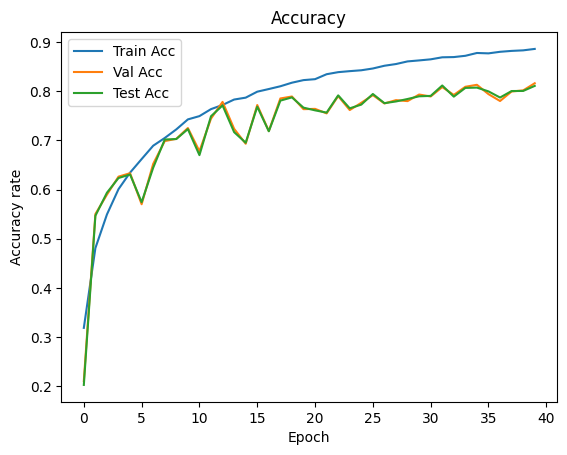

In [39]:
plt.figure()
plt.plot(cifar10_history13.history['accuracy'], label='Train Acc') #you can change it to cifar10_history23 / cifar10_history15
plt.plot(cifar10_history13.history['val_accuracy'], label='Val Acc')
plt.plot(cifar10_test_acc13, label='Test Acc')#you can change it to cifar_test_acc23 / cifar_test_acc15
plt.xlabel('Epoch'); plt.ylabel('Accuracy rate'); plt.legend(); plt.title('Accuracy')
plt.show()

#### 2. Learning Curve

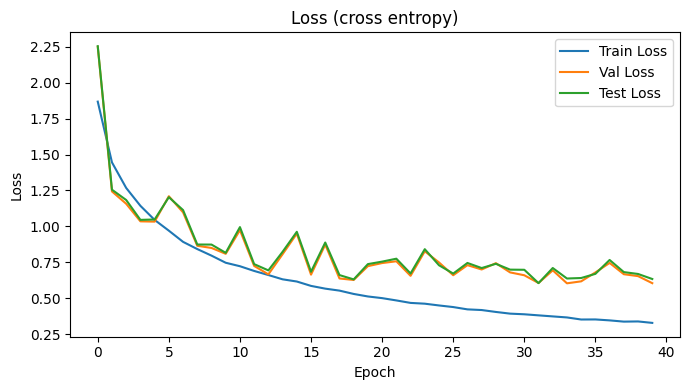

In [40]:
plt.figure(figsize=(7,4))
plt.plot(cifar10_history13.history.get('loss', []), label='Train Loss')#you can change it to history23 / history15
plt.plot(cifar10_history13.history.get('val_loss', []), label='Val Loss')
plt.plot(cifar10_test_loss13, label='Test Loss')#you can change it to cifar10_loss_acc23 / cifar10_loss_acc15
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss (cross entropy)')
plt.legend(); plt.tight_layout(); plt.show()

#### 3. Distributions of weights and biases

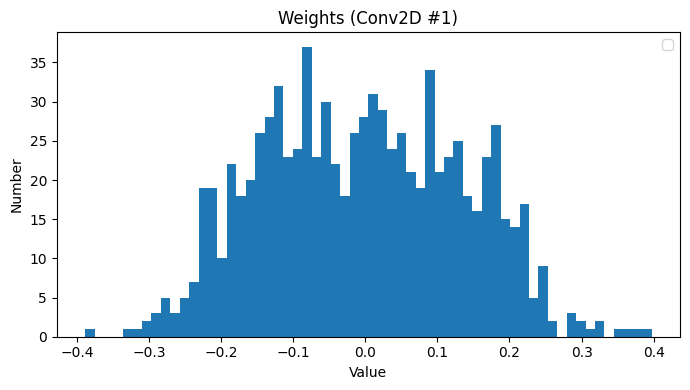

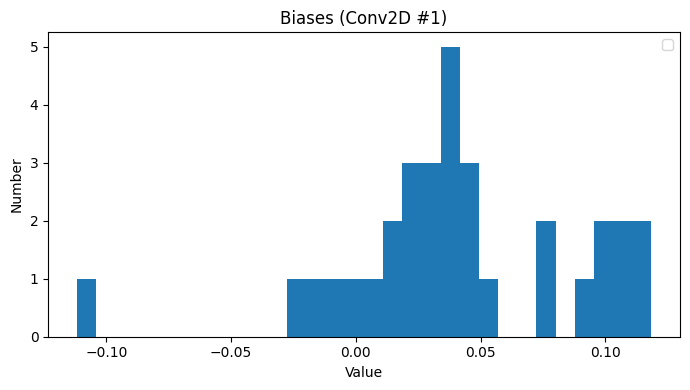

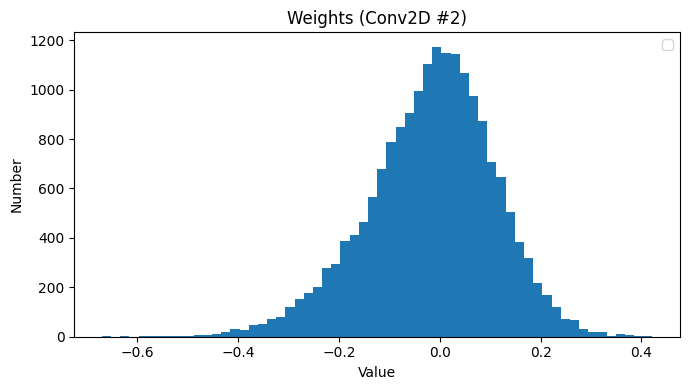

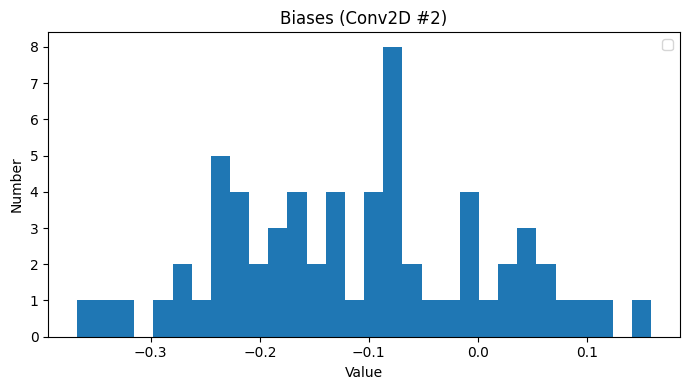

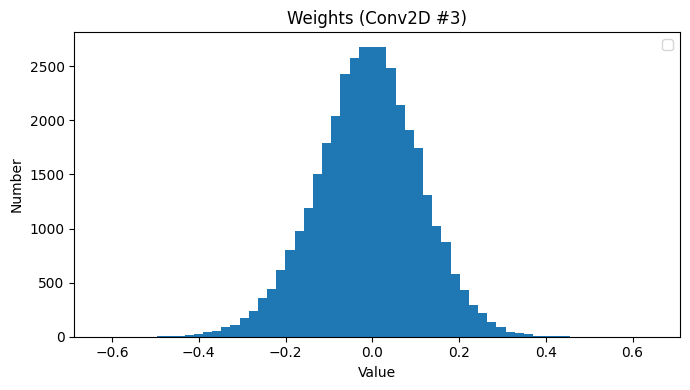

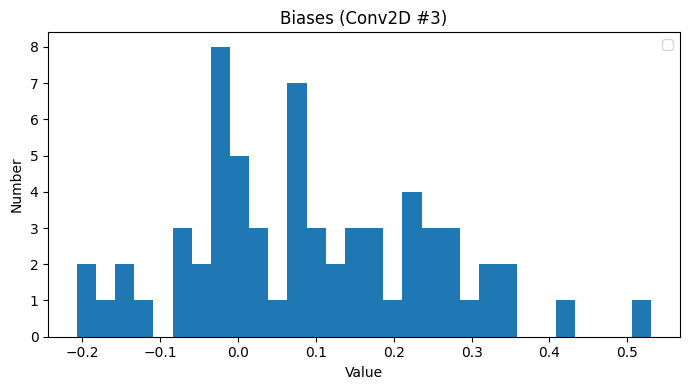

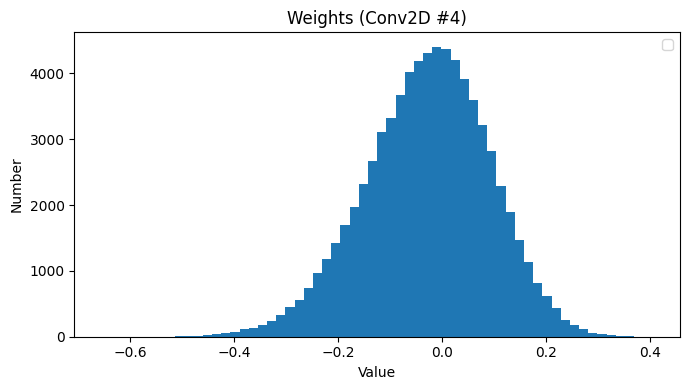

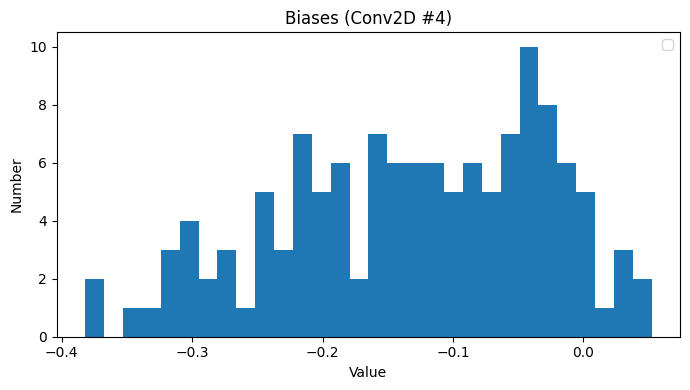

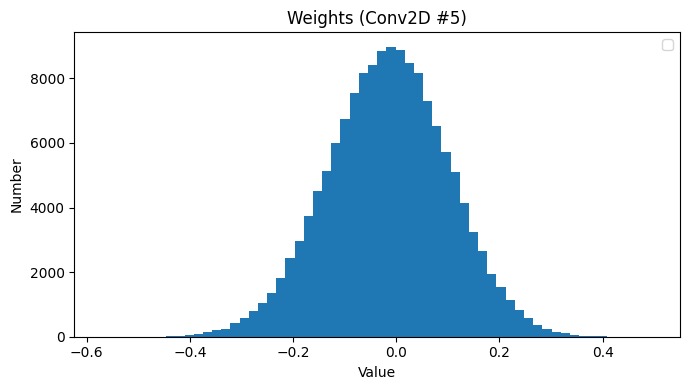

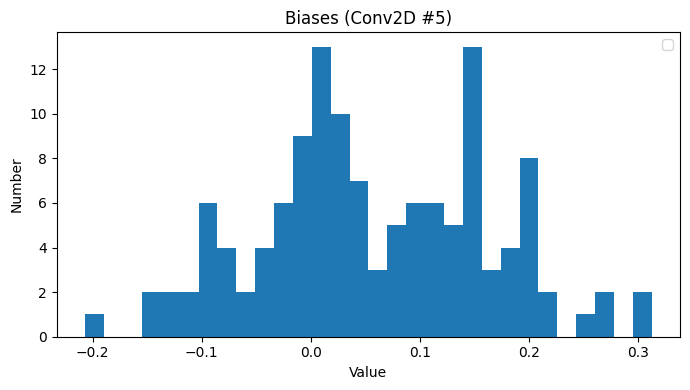

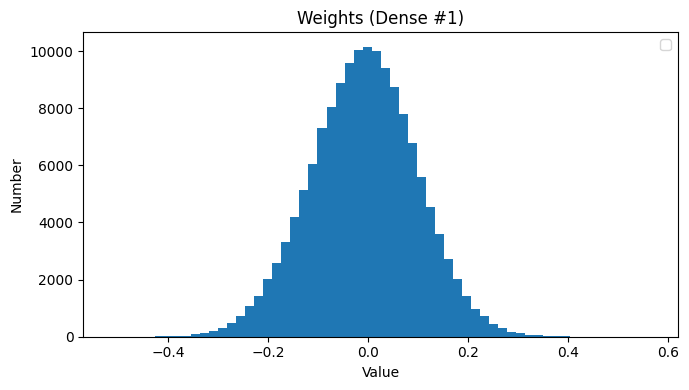

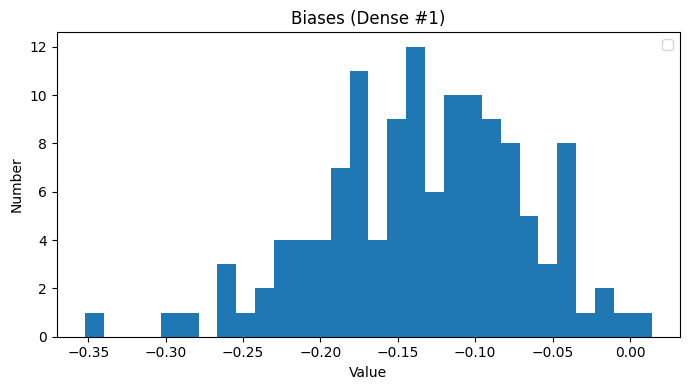

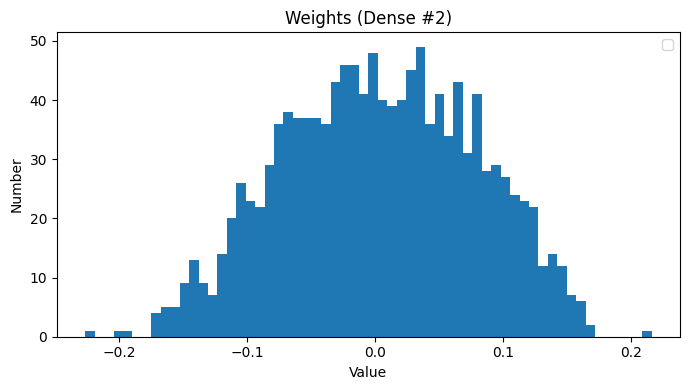

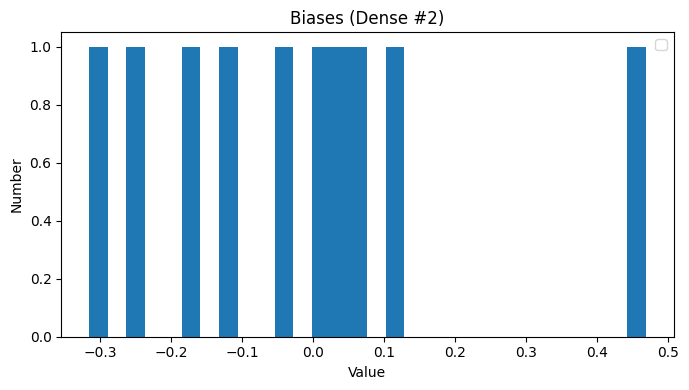

In [41]:
import tensorflow as tf
import matplotlib.pyplot as plt

conv_idx, dense_idx = 0, 0
for layer in cifar10_model13.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        conv_idx += 1
        w, *maybe_b = layer.get_weights()
        b = maybe_b[0] if maybe_b else None

        plt.figure(figsize=(7,4))
        plt.hist(w.flatten(), bins=60)
        plt.xlabel('Value'); plt.ylabel('Number'); plt.legend()
        plt.title(f'Weights (Conv2D #{conv_idx})')
        plt.tight_layout(); plt.show()

        if b is not None:
            plt.figure(figsize=(7,4))
            plt.hist(b.flatten(), bins=30)
            plt.xlabel('Value'); plt.ylabel('Number'); plt.legend()
            plt.title(f'Biases (Conv2D #{conv_idx})')
            plt.tight_layout(); plt.show()

    elif isinstance(layer, tf.keras.layers.Dense):
        dense_idx += 1
        w, *maybe_b = layer.get_weights()
        b = maybe_b[0] if maybe_b else None

        plt.figure(figsize=(7,4))
        plt.hist(w.flatten(), bins=60)
        plt.xlabel('Value'); plt.ylabel('Number'); plt.legend()
        plt.title(f'Weights (Dense #{dense_idx})')
        plt.tight_layout(); plt.show()

        if b is not None:
            plt.figure(figsize=(7,4))
            plt.hist(b.flatten(), bins=30)
            plt.xlabel('Value'); plt.ylabel('Number'); plt.legend()
            plt.title(f'Biases (Dense #{dense_idx})')
            plt.tight_layout(); plt.show()

### 2-2 Show some examples of correctly classified and miss-classified images and discuss your results.

In [42]:
y_train_int = np.argmax(y_train, axis=1)
y_val_int   = np.argmax(y_val, axis=1)
y_test_int  = np.argmax(y_test, axis=1)

#### Define the category names for each label

In [43]:
category_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


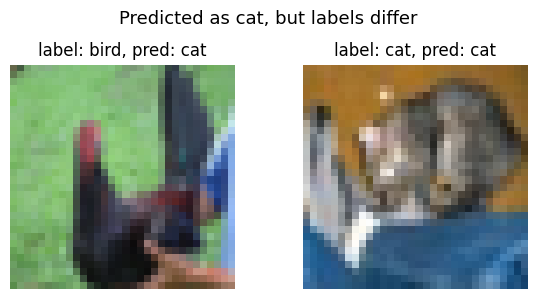

In [44]:
import numpy as np
import matplotlib.pyplot as plt

#Get predicted results
y_pred_probs = cifar10_model13.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Find index
correct_idx = np.where(y_pred == y_test_int)[0]
wrong_idx = np.where(y_pred != y_test_int)[0]

# Randomly choose samples
for idx_c in correct_idx:
    pred_label = y_pred[idx_c]
    true_label = y_test_int[idx_c]

# find the same pred but different label
    candidates = [i for i in wrong_idx if y_pred[i] == pred_label and y_test_int[i] != true_label]
    if len(candidates) > 0:
        idx_w = candidates[0]
        break

plt.figure(figsize=(6,3))

#plot the miss-classified image
plt.subplot(1,2,1)
plt.imshow(x_test[idx_w])
plt.title(f"label: {category_names[y_test_int[idx_w]]}, pred: {category_names[y_pred[idx_w]]}")
plt.axis('off')

#plot the correctly classified image
plt.subplot(1,2,2)
plt.imshow(x_test[idx_c])
plt.title(f"label: {category_names[y_test_int[idx_c]]}, pred: {category_names[y_pred[idx_c]]}")
plt.axis('off')

plt.suptitle(f"Predicted as {category_names[pred_label]}, but labels differ", fontsize=13)
plt.tight_layout()
plt.show()

The example already presented above, the LHS is miss-classified images and the RHS is correctly classified ones. I think why miss-classified might attribute to some reasons,
- **Rotation, slant** - such as **airplanes or automobiles**, appear in various angles and orientations. The model may confuse with other classes of shapes during training
- **Blurriness or Low Resolution** - images are unclear and cause the CNN model to fail to extract discriminative features.
- **Insufficient Network Depth / Capacity** - **A shallow CNN** has limited ability to capture high-level semantic features (like animal faces or wings)

### 2.3 observe the feature maps from different convolutional layers and describe how a feature map changes with increasing depth.

In [ ]:
cifar10_model13.summary()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


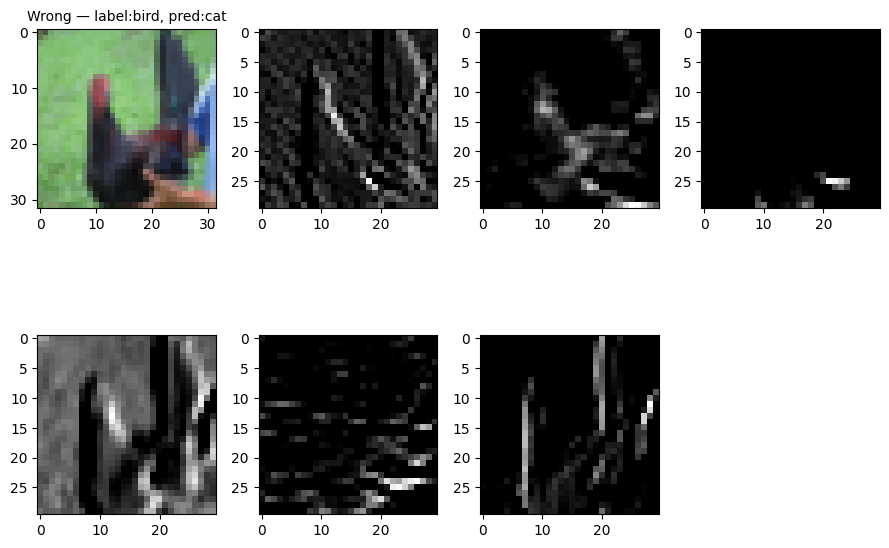

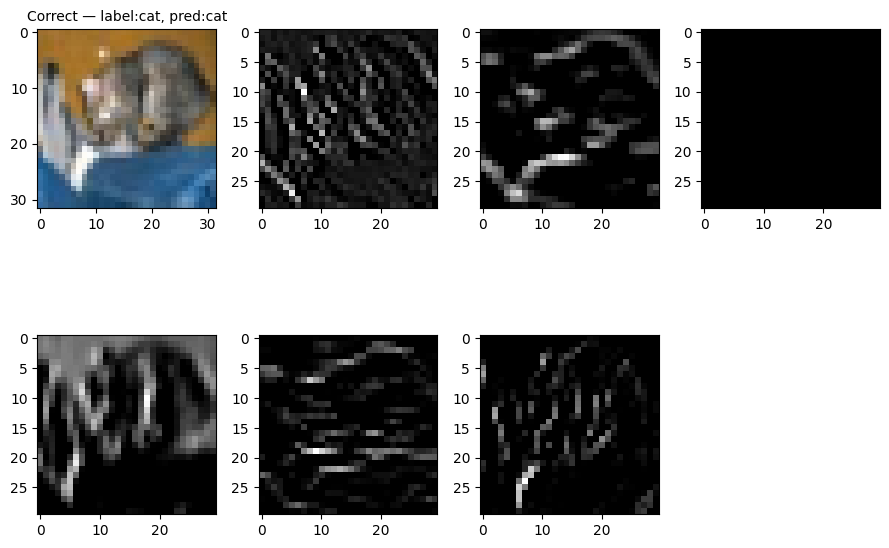

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.models import Model

# Data Preparation
if x_test.ndim == 3:
    x_test = x_test[..., np.newaxis]
x_test = x_test.astype("float32")
y_pred_probs = cifar10_model13.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
correct_idx = np.where(y_pred == y_test_int)[0]
wrong_idx   = np.where(y_pred != y_test_int)[0]

pairs = []
for idx_c in correct_idx:
    pred_label = y_pred[idx_c]
    true_label = y_test_int[idx_c]
    candidates = [i for i in wrong_idx if y_pred[i] == pred_label and y_test_int[i] != true_label]
    if len(candidates) > 0:
        idx_w = candidates[0]
        pairs.append((idx_c, idx_w, pred_label))
        break

idx_c, idx_w, pred_label = pairs[0]

# Build Model
inp = Input(shape=tuple(x_test.shape[1:]), dtype=tf.float32)
x = inp
first_conv_out = None
for lyr in cifar10_model13.layers:
    x = lyr(x)
    if first_conv_out is None and isinstance(lyr, Conv2D):
        first_conv_out = x
feat_model = Model(inputs=inp, outputs=first_conv_out)

# Define the function of ploting feature map
def plot_feature_map(img, title):
    act = feat_model.predict(img[None, ...], verbose=0)[0]
    rows, cols = 2, 3
    k = min(act.shape[-1], rows * cols)
    plt.figure(figsize=(9, 3.2 * rows))
    # Original
    plt.subplot(rows, cols + 1, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(title, fontsize=10)
    plt.axis('on')
    
    # Feature maps
    for i in range(k):
        plt.subplot(rows, cols + 1, i + 2)
        plt.imshow(act[:, :, i], cmap='gray')
        plt.axis('on')
    plt.tight_layout()
    plt.show()

# Plot
plot_feature_map(x_test[idx_w], f"Wrong — label:{category_names[y_test_int[idx_w]]}, pred:{category_names[y_pred[idx_w]]}")
plot_feature_map(x_test[idx_c], f"Correct — label:{category_names[y_test_int[idx_c]]}, pred:{category_names[y_pred[idx_c]]}")

- As the network depth increases, the feature maps gradually evolve from capturing low-level visual details to representing high-level semantic information.

  - In the **first** convolutional layer, the original shape of the digit is still visible.
  - In **intermediate** layers, the model combines these low-level patterns into more complex motifs such as stroke intersections or local contours, and the maps become sparser and harder to interpret visually.
  - In the **deeper** layers, the activations correspond to highly abstract class-specific features; the maps no longer resemble the input image but instead highlight meaningful concepts (e.g., loops, vertical strokes) that distinguish one class from another.
- Overall, with increasing depth:

  - **spatial resolution decreases**
  - **representations become more abstract**
  - **the model focuses on the most discriminative semantic features**

### 2.4 L2 regularization

In [50]:
cifar10_model13_l2, cifar10_history13_l2, cifar10_test_acc13_l2, cifar10_test_loss13_l2 = run_cnn_model_cifar(1,3,128,40,0.001)

Epoch 1/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2276 - loss: 2.9652
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.2467 - loss: 2.7213 - val_accuracy: 0.2242 - val_loss: 2.9714
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5076 - loss: 1.7721
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4526 - loss: 1.9652 - val_accuracy: 0.5046 - val_loss: 1.7822
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5496 - loss: 1.6539
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5288 - loss: 1.6831 - val_accuracy: 0.5470 - val_loss: 1.6223
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5998 - loss: 1.4323
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5874 - loss: 1.4971 - val_accuracy: 0.6074 - val_loss: 1.4178
Epoch 5/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6603 - loss: 1.2597
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6325 - loss: 1.3602 - val_accuracy: 0.662

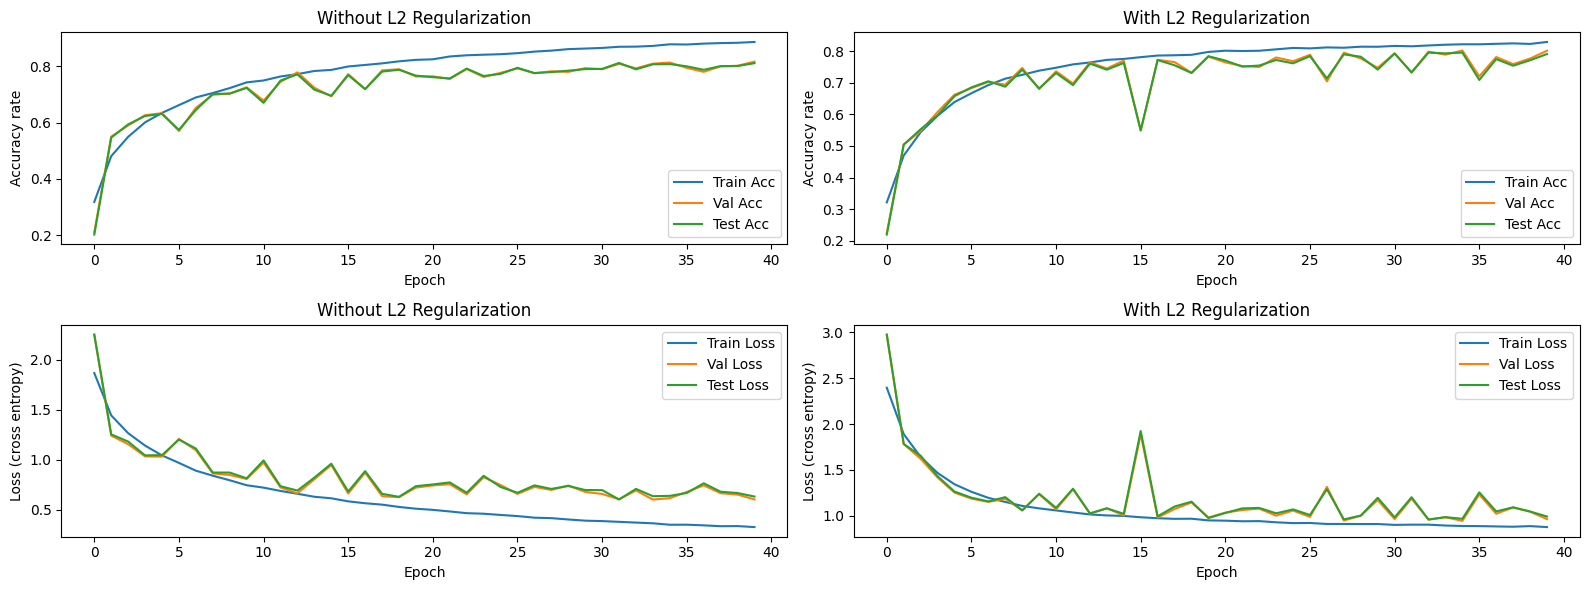

In [51]:
plt.figure(figsize=(16, 6))

#Accuracy
plt.subplot(2, 2, 1)
plt.plot(cifar10_history13.history['accuracy'], label='Train Acc')
plt.plot(cifar10_history13.history['val_accuracy'], label='Val Acc')
plt.plot(cifar10_test_acc13, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy rate')
plt.legend()
plt.title('Without L2 Regularization')

plt.subplot(2, 2, 2)
plt.plot(cifar10_history13_l2.history['accuracy'], label='Train Acc')
plt.plot(cifar10_history13_l2.history['val_accuracy'], label='Val Acc')
plt.plot(cifar10_test_acc13_l2, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy rate')
plt.legend()
plt.title('With L2 Regularization')

#Loss (Learning Curve)
plt.subplot(2, 2, 3)
plt.plot(cifar10_history13.history['loss'], label='Train Loss')
plt.plot(cifar10_history13.history['val_loss'], label='Val Loss')
plt.plot(cifar10_test_loss13, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross entropy)')
plt.legend()
plt.title('Without L2 Regularization')

plt.subplot(2, 2, 4)
plt.plot(cifar10_history13_l2.history['loss'], label='Train Loss')
plt.plot(cifar10_history13_l2.history['val_loss'], label='Val Loss')
plt.plot(cifar10_test_loss13_l2, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross entropy)')
plt.legend()
plt.title('With L2 Regularization')

plt.tight_layout()
plt.show()

#### Accuracy / Learning Curve
- **Without L2 regularization**, the training accuracy rapidly rises and approaches **0.8–0.85**, while the validation and testing accuracies plateau around **0.75–0.8**.
The training loss steadily decreases close to zero, but the validation loss shows minor fluctuations in later epochs, suggesting mild overfitting.

- **With L2 regularization**, the training curve becomes steeper in the early epochs, and the convergence of all three accuracies (train/val/test) occurs more sharply.
Although the loss initially fluctuates more, it stabilizes after mid-training, and all accuracy curves align closely toward the end.
This indicates that L2 regularization constrains the weight magnitudes, leading to tighter alignment across datasets and better generalization, even if the early training dynamics appear more abrupt.

- **Compared to MNIST, the effect of L2 on CIFAR-10 is less about smoothing the curves and more about enforcing convergence consistency under higher data complexity.**

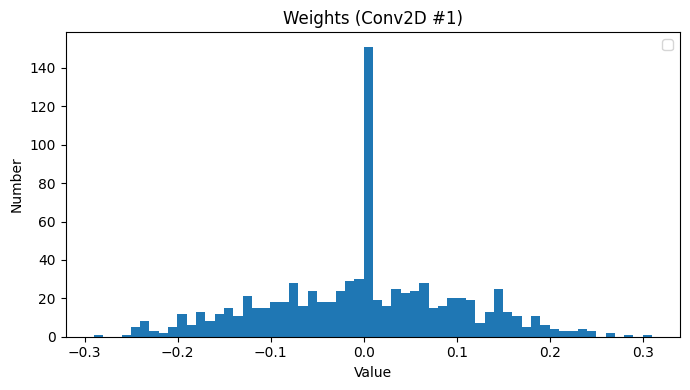

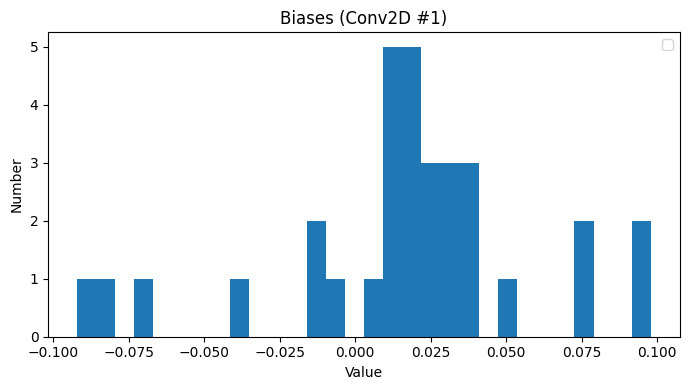

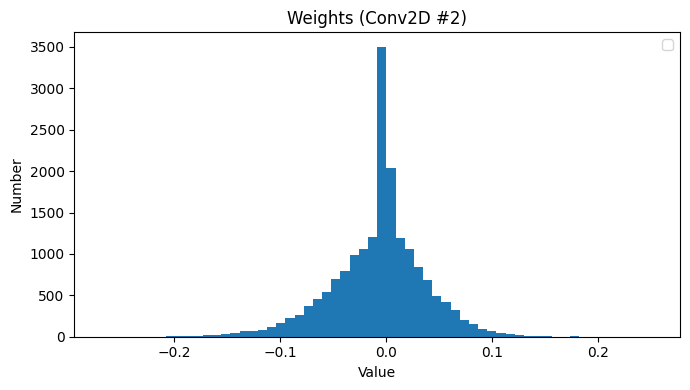

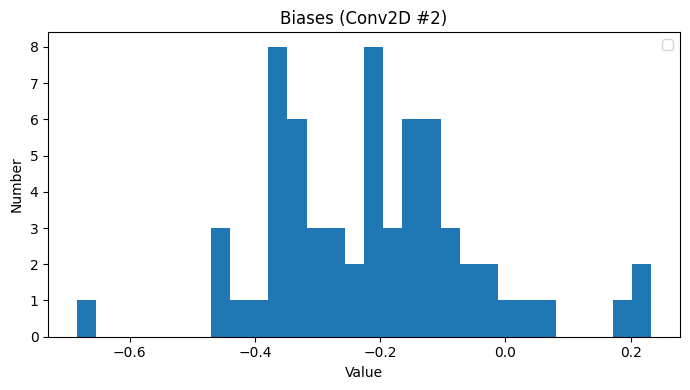

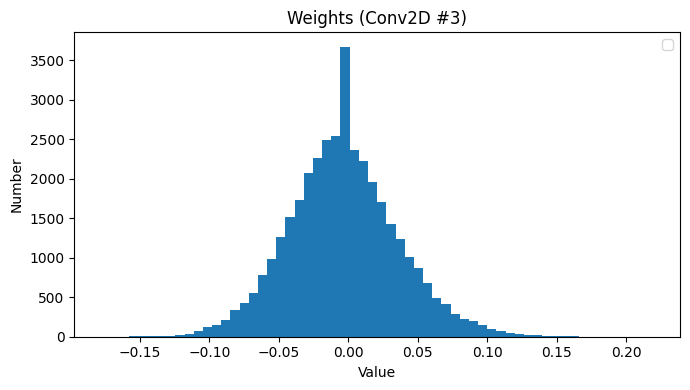

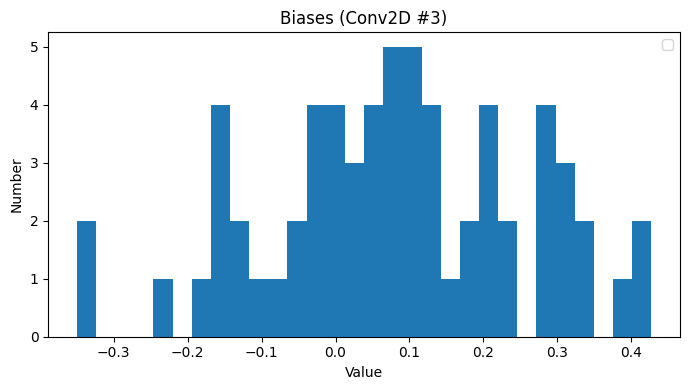

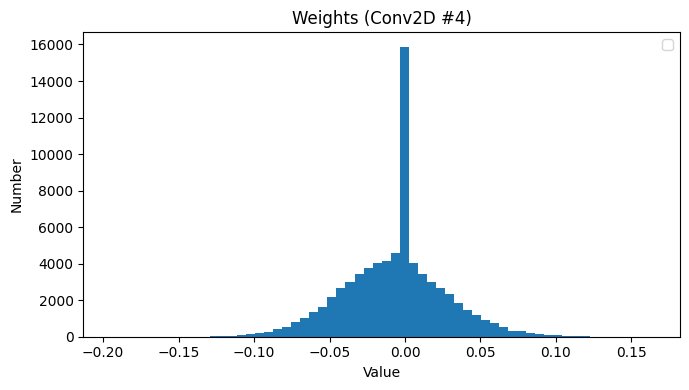

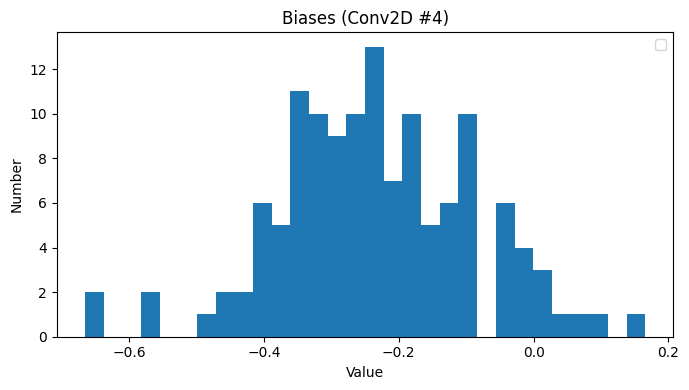

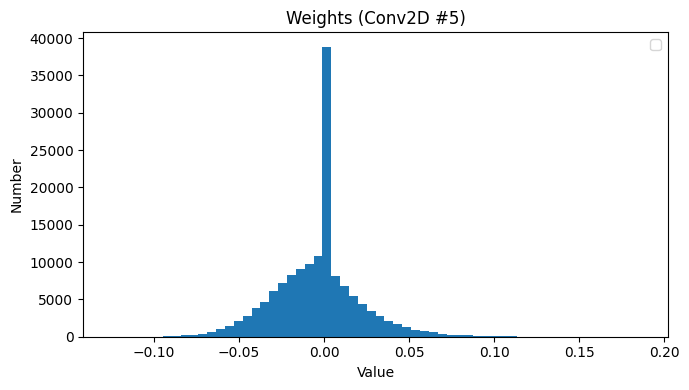

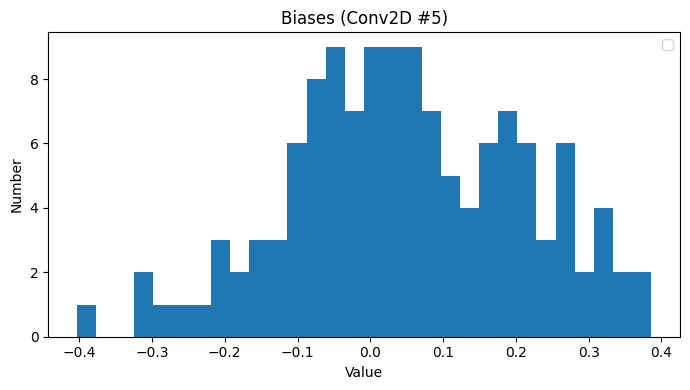

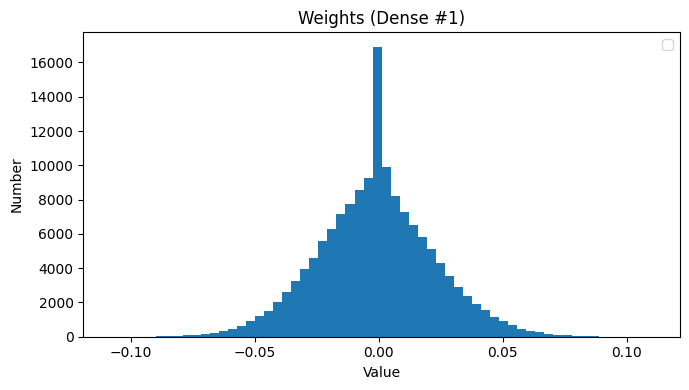

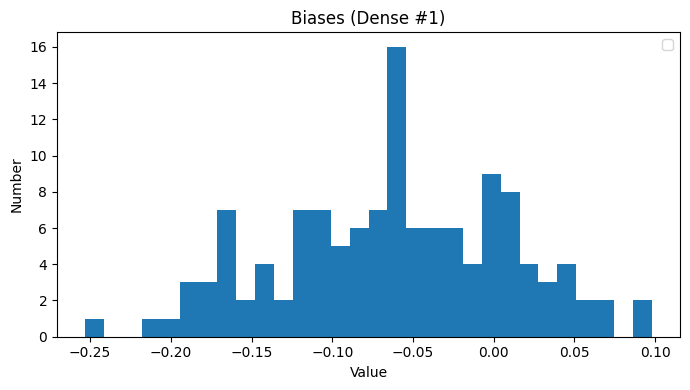

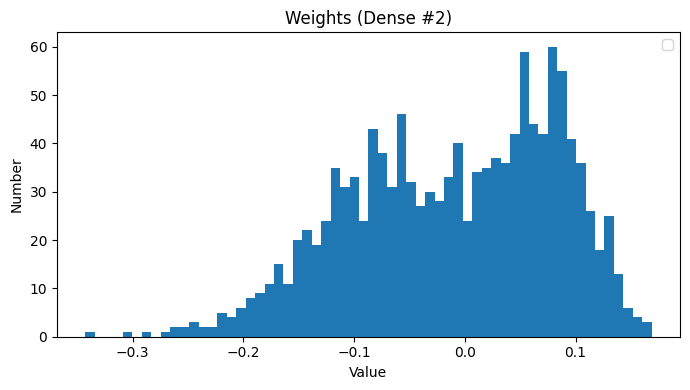

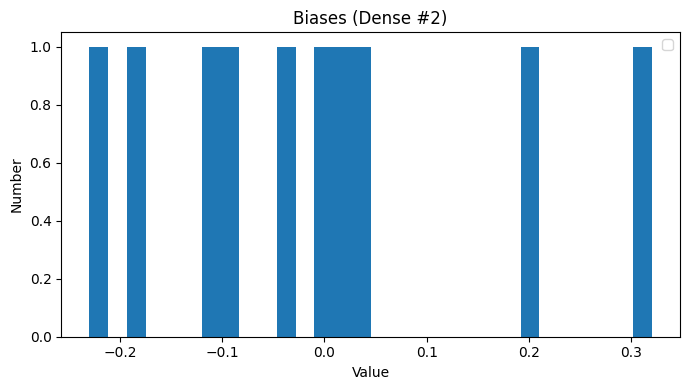

In [52]:
#Histograms of bias and weights (with L2 regularization)
conv_idx, dense_idx = 0, 0
for layer in cifar10_model13_l2.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        conv_idx += 1
        w, *maybe_b = layer.get_weights()
        b = maybe_b[0] if maybe_b else None

        plt.figure(figsize=(7,4))
        plt.hist(w.flatten(), bins=60)
        plt.xlabel('Value'); plt.ylabel('Number'); plt.legend()
        plt.title(f'Weights (Conv2D #{conv_idx})')
        plt.tight_layout(); plt.show()

        if b is not None:
            plt.figure(figsize=(7,4))
            plt.hist(b.flatten(), bins=30)
            plt.xlabel('Value'); plt.ylabel('Number'); plt.legend()
            plt.title(f'Biases (Conv2D #{conv_idx})')
            plt.tight_layout(); plt.show()

    elif isinstance(layer, tf.keras.layers.Dense):
        dense_idx += 1
        w, *maybe_b = layer.get_weights()
        b = maybe_b[0] if maybe_b else None

        plt.figure(figsize=(7,4))
        plt.hist(w.flatten(), bins=60)
        plt.xlabel('Value'); plt.ylabel('Number'); plt.legend()
        plt.title(f'Weights (Dense #{dense_idx})')
        plt.tight_layout(); plt.show()

        if b is not None:
            plt.figure(figsize=(7,4))
            plt.hist(b.flatten(), bins=30)
            plt.xlabel('Value'); plt.ylabel('Number'); plt.legend()
            plt.title(f'Biases (Dense #{dense_idx})')
            plt.tight_layout(); plt.show()

#### Histogram of the weight distributions
  - **Without L2**, the weight histogram exhibits a **near-Gaussian** shape with a relatively wide spread. This implies that the model allows large weight magnitudes, enabling more flexibility but also increasing the risk of overfitting.

  - **With L2**, the weight distribution becomes **sharply peaked around zero**, and the range of values is significantly narrower. This demonstrates that the L2 penalty effectively suppresses large weights by constraining their magnitudes, leading to a smoother, more regularized parameter space and improved generalization capability.
#### Histogram of the bias distributions
  - **Without L2**, the bias values are **mostly distributed in a wider range around negative values**, indicating that the network tends to apply small downward shifts to the activations in the dense layer.
  - **With L2**, the bias distribution becomes **more concentrated near zero** and slightly shifts toward positive values.